# lightGBM - histogram-based

- Modified from: https://github.com/meanxai/machine_learning/blob/main/12.LGBM/1.histogram_based.py
- A detailed description of this code can be found in https://youtu.be/APZyWo9hIj0

In [1]:
import numpy as np
from sklearn.datasets import make_blobs
from multiprocessing.pool import Pool
import matplotlib.pyplot as plt

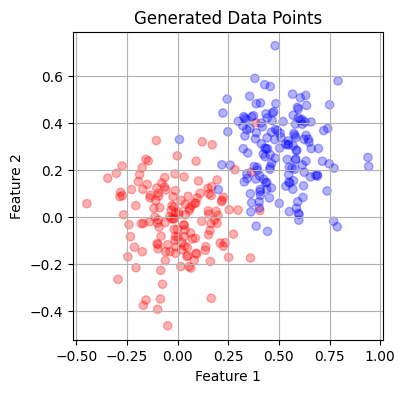

In [2]:
def create_training_dataset(
    n_samples=300,
    n_features=2,
    centers=[[0.0, 0.0], [0.5, 0.3]],
    cluster_std=0.15,
    center_box=(-1.0, 1.0),
):
    """Create a training dataset using make_blobs. Each blob represents a cluster of points.
    n_samples: The total number of samples (points) to generate.
    n_features: The number of features (dimensions) for each sample. Typically 2 for 2D blobs.
    centers: The number of blobs (clusters) to generate.
    cluster_std: The standard deviation of each blob.
    random_state: An optional seed for reproducibility.

    The y output (e.g. the target value) of make_blobs represents the cluster
    labels for each sample. By default, the cluster labels are integers starting from 0 and going up to centers - 1
    """
    x, y = make_blobs(
        n_samples=n_samples,
        n_features=n_features,
        centers=centers,
        cluster_std=cluster_std,
        center_box=center_box,
    )
    return x, y


def plot_dataset(x, y):
    """Plot the dataset with color coding for different clusters."""
    plt.figure(figsize=(4, 4))
    colors = ["red", "blue"]
    # alpha=0.3: This sets the transparency (alpha value) of the points
    plt.scatter(x[:, 0], x[:, 1], c=[colors[a] for a in y], alpha=0.3)
    plt.title("Generated Data Points")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid()
    plt.show()


# Create the training dataset
x, y = create_training_dataset()

# Plot the dataset
plot_dataset(x, y)


In [3]:
def print_2d_histograms(
    feature0_bins, feature1_bins, feature0_frequencies, feature1_frequencies
):
    """
    Print histograms to graph.

    Parameters:
    feature0_bins (numpy array): Bin edges for feature 0.
    feature1_bins (numpy array): Bin edges for feature 1.
    feature0_frequencies (numpy array): Weighted frequencies for feature 0.
    feature1_frequencies (numpy array): Weighted frequencies for feature 1.
    """
    fig, axs = plt.subplots(2, figsize=(8, 6))

    axs[0].bar(
        feature0_bins[:-1],
        feature0_frequencies,
        width=feature0_bins[1] - feature0_bins[0],
    )
    axs[0].set_title("Feature 1 histogram")
    axs[0].set_xlabel("Value")
    axs[0].set_ylabel("Weighted Frequency")

    axs[1].bar(
        feature1_bins[:-1],
        feature1_frequencies,
        width=feature1_bins[1] - feature1_bins[0],
    )
    axs[1].set_title("Feature 2 histogram")
    axs[1].set_xlabel("Value")
    axs[1].set_ylabel("Weighted Frequency")

    fig.tight_layout()

    plt.show()

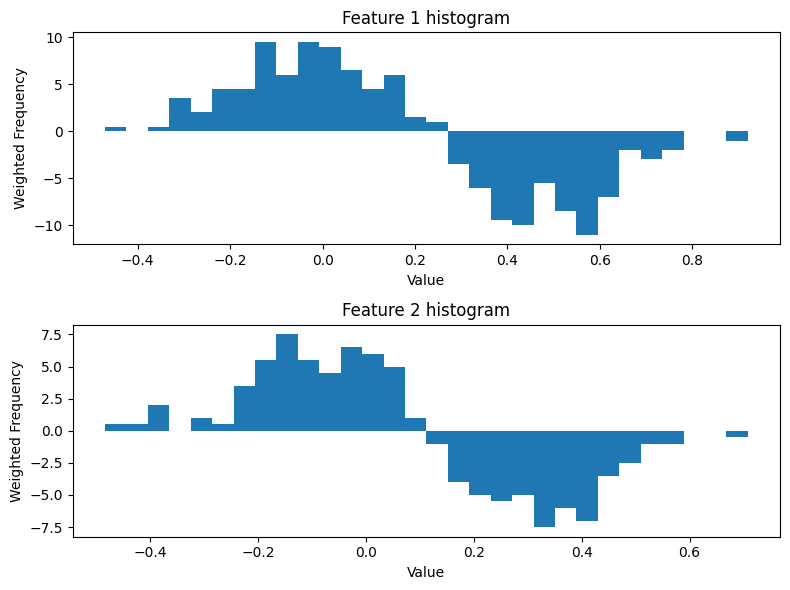

In [4]:
y0 = np.ones(shape=y.shape) * 0.5  # initial prediction
g = -(y - y0)  # negative residual (an array)
h = y0 * (1.0 - y0)  # Hessian.

# Create a histogram of the parent node for each feature
n_bin = 30  # the number of bins
# weights=g: Here, g is an array of weights that corresponds to each element
# in x[:, 0]. This parameter allows you to weigh the contribution of each data
# point when calculating the histogram.
g_sum_0_parent, f0_bin = np.histogram(x[:, 0], n_bin, weights=g)  # feature 0
g_sum_1_parent, f1_bin = np.histogram(x[:, 1], n_bin, weights=g)  # feature 1

print_2d_histograms(f0_bin, f1_bin, g_sum_0_parent, g_sum_1_parent)

In [5]:
def find_local_split_point(f, s_point):
    # G, H, r, p_score
    # from calling side
    GL = HL = 0.0
    l_bound = -np.inf  # lower left bound
    max_gain = -np.inf

    for j in s_point:
        # split the parent node into the left and right nodes.
        # "parent nodes" are basically the histogram on certain feature
        # split to left and right are basically splitting the histogram
        # to two halves based on bins, e.g.
        # parent : [bin0, bin1, bin2, bin3]
        # split0 : Left[bin0], Right[bin1, bin2, bin3]
        # split1 : Left[bin0, bin1], Right[bin2, bin3]
        # ...
        left = np.where(np.logical_and(f > l_bound, f <= j))[0]
        right = np.where(f > j)[0]

        # After splitting the parent node, calculate the scores of its children.
        GL += g[left].sum()
        HL += (h[left] * (1.0 - h[left])).sum()
        GR = G - GL
        HR = H - HL

        # Calculate the gain for this split
        gain = (GL**2) / (HL + r) + (GR**2) / (HR + r) - p_score

        # Find the maximum gain.
        if gain > max_gain:
            max_gain = gain
            b_point = j  # best split point
        l_bound = j

    return b_point, max_gain


G = g.sum()
H = h.sum()
r = 0.0
gamma = 0.0
p_score = (G**2) / (H + r)  # parent's score before splitting the node

# Find global best split point through parallel processing
# vertical partitioning method is used.
mp = Pool(2)
args = [[x[:, 0], f0_bin], [x[:, 1], f1_bin]]
# Find the best split point of each feature in parallel
ret = mp.starmap_async(find_local_split_point, args)
mp.close()
mp.join()

results = ret.get()
p1 = results[0][0]
p2 = results[1][0]
gain1 = results[0][1]
gain2 = results[1][1]

if gain1 > gain2:
    best_feature_id = 0
    best_split_pt_on_best_feature = p1
else:
    best_feature_id = 1
    best_split_pt_on_best_feature = p2

print("\nbest feature id =", best_feature_id)
print("best split point =", best_split_pt_on_best_feature.round(3))


best feature id = 0
best split point = 0.294
